In [1]:
from activation_visualization import dataset_average, effective_receptive_field, backprop_maximization, activation_triggered_average, normalizeZeroOne, get_input_output_shape
from models.model_builder import load_model
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets

import torch
from matplotlib import pyplot as plt
from tqdm import tqdm
from torchinfo import summary
import numpy as np
import retinal_rl_wrapper as retinal_stats

In [2]:
model = load_model("../models/lindsey_analogon_minikernel")
transf = [transforms.ToTensor()]
in_channels = model.in_channelss
if in_channels==1:
    transf.append(transforms.Grayscale())
train_data = datasets.CIFAR10(root="../data", train=True, download=True, transform=transforms.Compose(transf))
train_loader = DataLoader(train_data, batch_size=256, shuffle=False)

summary(model)

Files already downloaded and verified


Layer (type:depth-idx)                   Param #
SimpleCNN                                --
├─ResConv2d: 1-1                         --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  320
│    │    └─Conv2d: 3-2                  9,248
│    │    └─Conv2d: 3-3                  9,248
│    │    └─Conv2d: 3-4                  9,248
├─ReLU: 1-2                              --
├─Softmax: 1-3                           --
├─ModuleList: 1-4                        --
│    └─ResConv2d: 2-2                    --
│    │    └─Sequential: 3-5              36,992
│    └─ResConv2d: 2-3                    --
│    │    └─Sequential: 3-6              36,992
│    └─ResConv2d: 2-4                    --
│    │    └─Sequential: 3-7              36,992
├─Linear: 1-5                            327,690
Total params: 466,730
Trainable params: 466,730
Non-trainable params: 0

In [8]:
model = model.get_sequential()
summary(model, (1,in_channels,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─ResConv2d: 1-1                         [1, 32, 32, 32]           --
│    └─Sequential: 2-1                   [1, 32, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 32, 38, 38]           320
│    │    └─Conv2d: 3-2                  [1, 32, 36, 36]           9,248
│    │    └─Conv2d: 3-3                  [1, 32, 34, 34]           9,248
│    │    └─Conv2d: 3-4                  [1, 32, 32, 32]           9,248
├─ReLU: 1-2                              [1, 32, 32, 32]           --
├─ResConv2d: 1-3                         [1, 32, 32, 32]           --
│    └─Sequential: 2-2                   [1, 32, 32, 32]           --
│    │    └─Conv2d: 3-5                  [1, 32, 38, 38]           9,248
│    │    └─Conv2d: 3-6                  [1, 32, 36, 36]           9,248
│    │    └─Conv2d: 3-7                  [1, 32, 34, 34]           9,

## Intermediate Representation

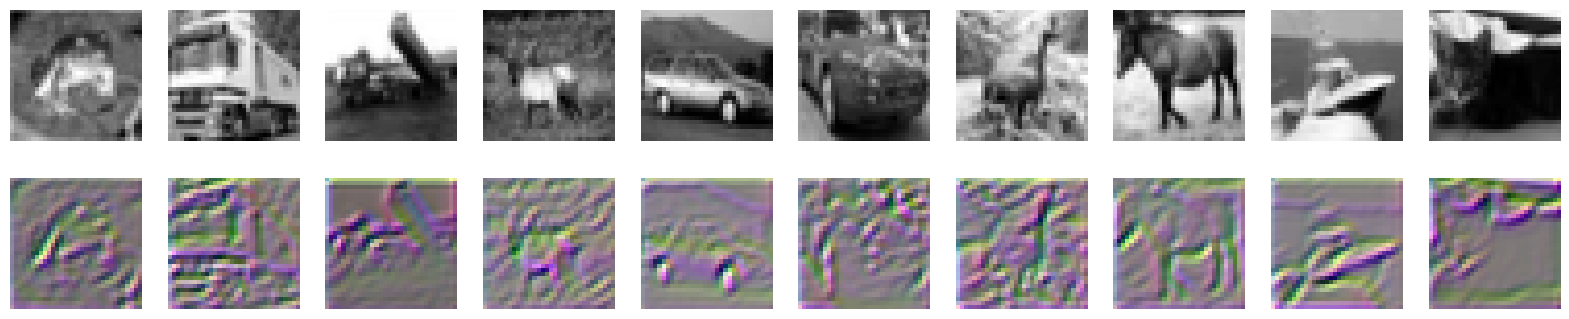

In [10]:
imgs = next(iter(train_loader))
processed = model[:3](imgs[0]).detach()

fig, axes = plt.subplots(2, 10, figsize=(20,4))
for ax, im in zip(axes[0], imgs[0]):
    ax.imshow(im.movedim(0,2), cmap='gray')
    ax.axis('off')
for ax, im in zip(axes[1], processed):
    ax.imshow(normalizeZeroOne(im[:min(3, im.shape[0])].movedim(0,2)), cmap='gray')
    ax.axis('off')

## Receptive Fields

In [11]:
eff_rfs = effective_receptive_field(model[:3], n_batch=1, fill_value=0.5)
if len(eff_rfs)==1:
    plt.imshow(torch.mean(eff_rfs[0], dim=0), cmap="gray")
    plt.axis('off')
else:
    fig, axes = plt.subplots(4, 8, figsize=(24,12))
    for eff_rf, ax in zip(eff_rfs, axes.flat):
        ax.imshow(torch.mean(eff_rf, dim=0), cmap="gray")
        ax.axis('off')

UnboundLocalError: cannot access local variable 'in_size' where it is not associated with a value

The following cell should be run only with a GPU backend!

Other than that, it seems that the activation triggered average results in 'nicer' RFs for the first layer, in higher layers the effective receptive fields are usually smoother (and a lot faster!)

  0%|          | 1/256 [00:00<?, ?it/s]

100%|██████████| 256/256 [00:02<00:00, 103.13it/s]


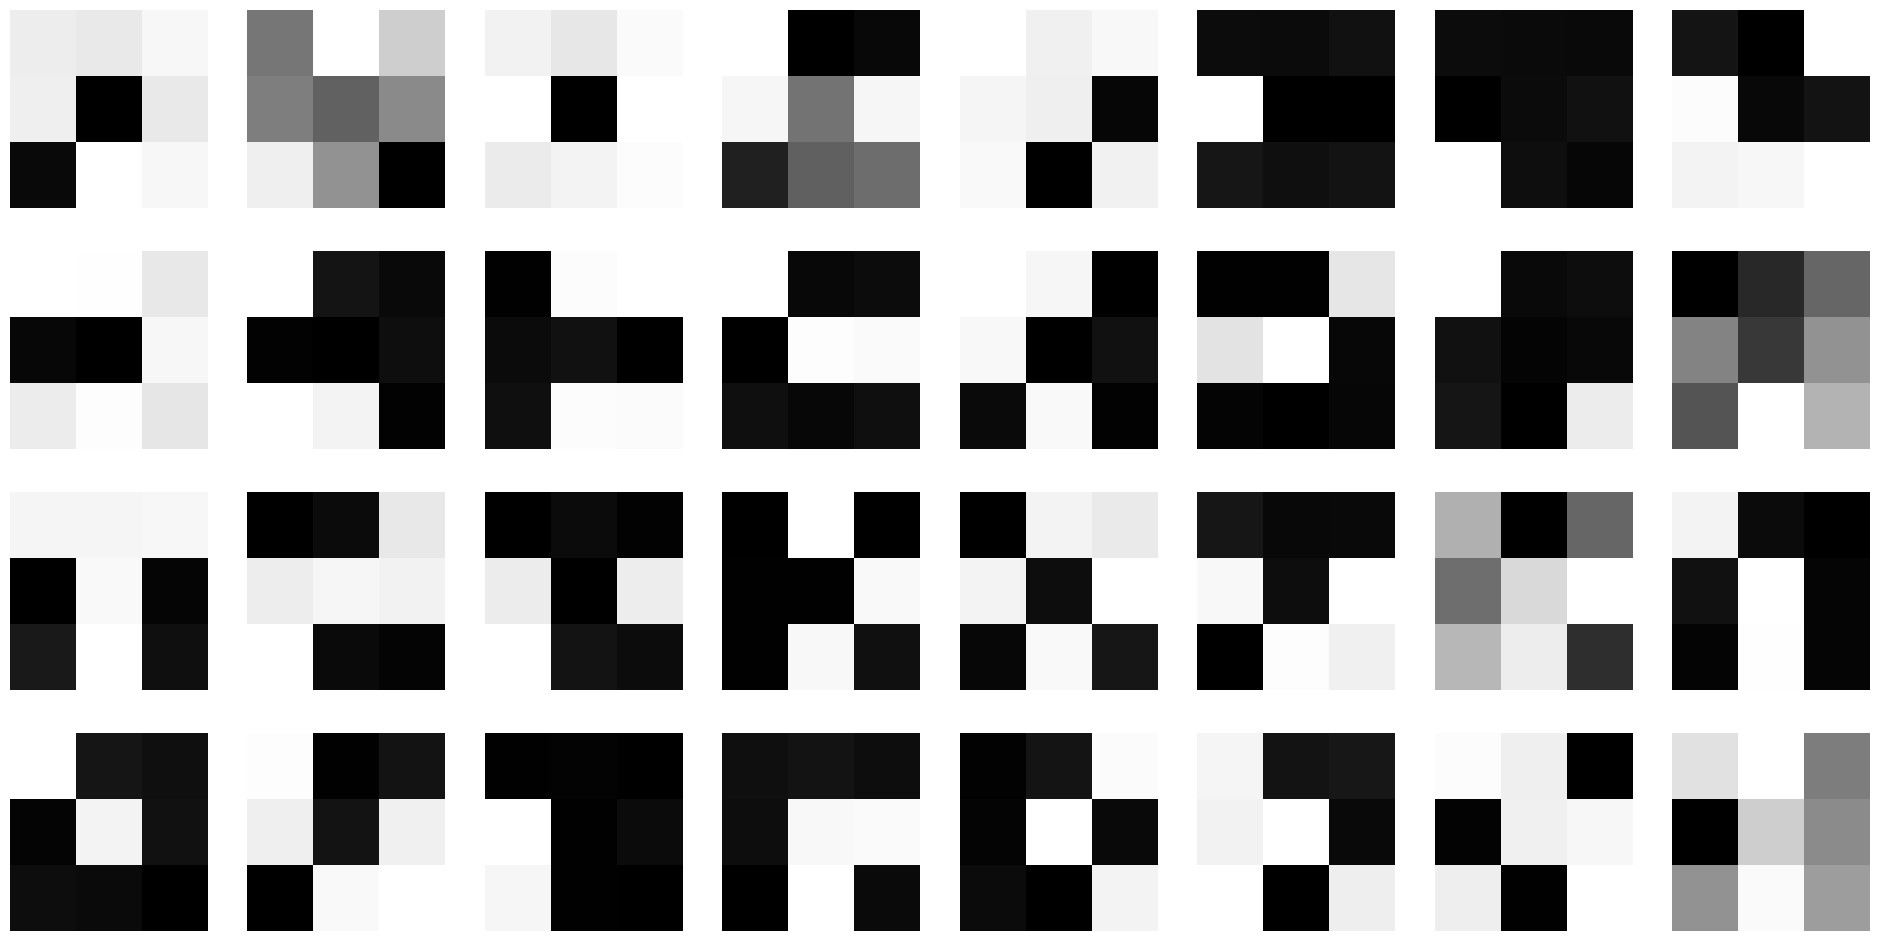

In [18]:
eff_rfs = activation_triggered_average(model[:1], n_iter=256)

if len(eff_rfs)==1:
    plt.imshow(torch.mean(eff_rfs[0], dim=0), cmap="gray")
    plt.axis('off')
else:
    fig, axes = plt.subplots(4, 8, figsize=(24,12))
    for eff_rf, ax in zip(eff_rfs, axes.flat):
        ax.imshow(torch.mean(eff_rf, dim=0), cmap="gray")
        ax.axis('off')

100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


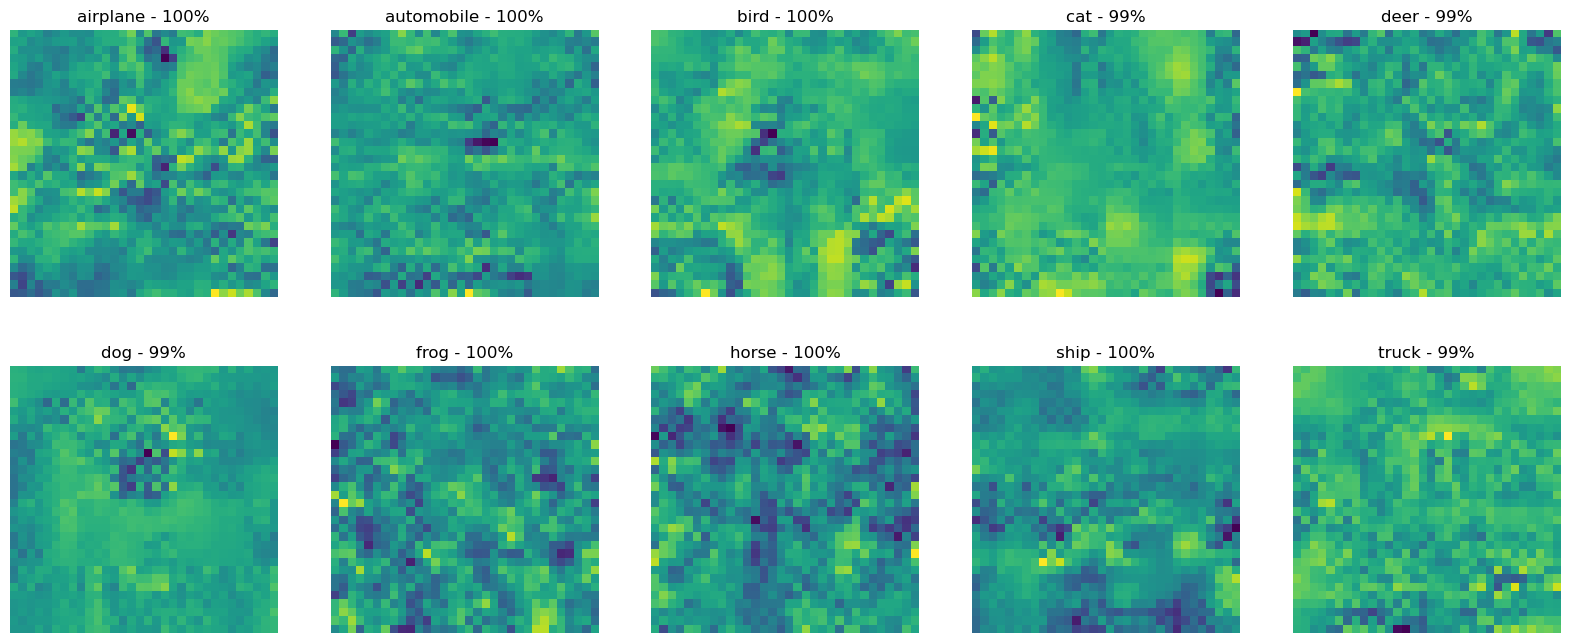

In [42]:
back_maxs = backprop_maximization(model[:-1], n_iter=128, batch_size=1, reduction=True, smoothened=True)

fig, axes = plt.subplots(2, 5, figsize=(20,8))
for class_name, back_max, ax in zip(train_data.classes, back_maxs, axes.flat):
    out = model(back_max.repeat(1,1,1,1))
    index = out.argmax()
    prob = out.max()

    ax.imshow(back_max.movedim(0,2))
    ax.axis('off')
    ax.set_title(class_name + " - {0:.0%}".format(prob))

100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


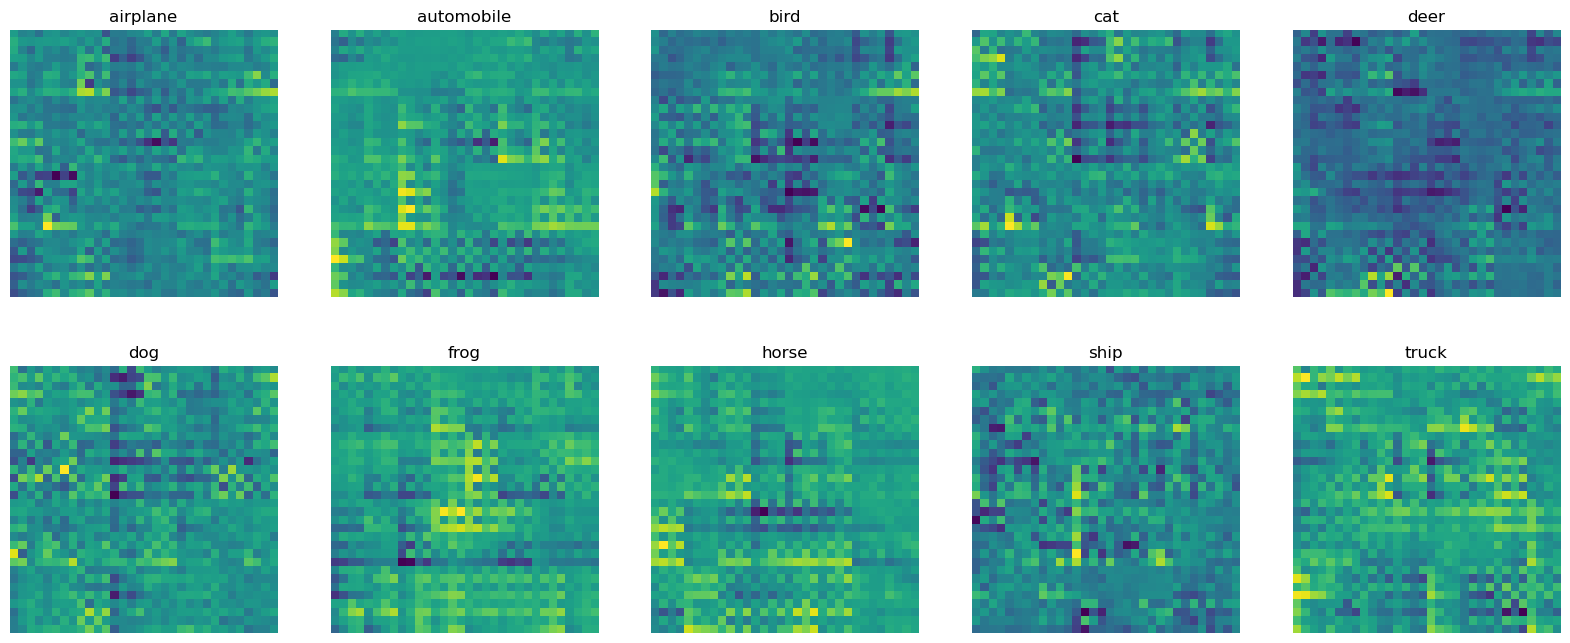

In [43]:
eff_rfs = effective_receptive_field(model, n_batch=512)
fig, axes = plt.subplots(2, 5, figsize=(20,8))

for class_name, eff_rf, ax  in zip(train_data.classes, eff_rfs, axes.flat):
    ax.imshow(normalizeZeroOne(eff_rf.movedim(0,2)))
    ax.axis('off')
    ax.set_title(class_name)